In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
from scipy.stats import zscore
from scipy.special import logit
from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests

In [2]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
# data_dir = '../../data/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_neurogenesis_rd = pd.read_csv(data_dir + 'tiklova_neurogenesis/rd_pc2.tab', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.scores.txt', sep='\t', index_col=0)
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)
tiklova_kw = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
# tiklova_kw = pd.read_csv(data_dir + 'tiklova_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

In [3]:
tiklova_kw = tiklova_kw.loc[tiklova_psix.index]
tiklova_kw['qvals'] = multipletests(tiklova_kw.pvals, method='fdr_bh')[1]

geary_C = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_autocor_one_matrix/tiklova_GearyC_k100.tab',
                     sep='\t', index_col=0)

geary_C.columns = ['C_score', 'pvals']

In [ ]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
    song_mrna_event = pd.read_csv(data_dir + 'song/mrna_per_event.tab', sep='\t', index_col=0)
    song_rd = pd.read_csv(data_dir + 'song/rd_pc2.tab', sep='\t', index_col=0)
    song_PSI = pd.read_csv(data_dir + 'song/skipped_exons_psi.tab', sep='\t', index_col=0)
    song_psix = pd.read_csv('../psix_runs/song.scores.txt', sep='\t', index_col=0)
    song_cross_psix = pd.read_csv('../psix_runs/song.cross_scores.tab', sep='\t', index_col=0)
    song_kw = pd.read_csv('~/sc_splicing_regulation/sc/song_kw.tab', sep='\t', index_col=0)

    song_kw = song_kw.loc[song_psix.index]
    song_kw['qvals'] = multipletests(song_kw.pvals, method='fdr_bh')[1]

    song_geary_C = pd.read_csv('~/sc_splicing_regulation/sc/song_autocor/song_GearyC_k30.tab',
                         sep='\t', index_col=0)
    
    song_geary_C = song_geary_C.loc[song_psix.index & song_geary_C.index]

    song_geary_C.columns = ['C_score', 'pvals']

In [4]:
def get_ranks(scores_df, score_name, bins=50):
    score_series = scores_df.sort_values(score_name).sort_values(score_name)
    ranks_dict = dict()
    total_exons = len(scores_df.index)
    exons_per_rank = int(total_exons/bins)
    for i in range(bins):
        bin_str = i+1
        bin_lims = -exons_per_rank*i
        if i == bins - 1:
            rank_exons = scores_df.sort_values(score_name).index[:bin_lims]
        elif i == 0:
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:]
        else:
            
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:bin_lims]
        ranks_dict.update({bin_str:rank_exons})
    return ranks_dict
    

def make_comparison(df1, df2, score1, score2, bins=50):
    
    rank_df = pd.DataFrame()
    rank_df_exons = pd.DataFrame()
    
    ranks1 = get_ranks(df1, score1, bins)
    ranks2 = get_ranks(df2, score2, bins)
    
    for i in range(1, bins+1):
        shared_list = []
        shared_exons_list = []
        r1_i = ranks1[i]
        for j in range(1, bins+1):
            r2_j = ranks2[j]
            
            shared = len(r1_i & r2_j)
            
            shared_list.append(len(r1_i & r2_j))
            shared_exons_list.append(r1_i & r2_j)
            
        rank_df['bin_' + str(i)] = shared_list
        rank_df_exons['bin_' + str(i)] = shared_exons_list
        
    rank_df.index = ['bin_' + str(i) for i in range(1, bins+1)]
    rank_df_exons.index = ['bin_' + str(i) for i in range(1, bins+1)]
    
    return rank_df, rank_df_exons
        

Text(50.0, 0.5, 'Psix ranks')

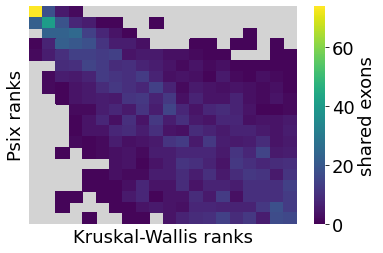

In [5]:
comparison, comparison_exons = make_comparison(tiklova_kw.loc[tiklova_psix.index], tiklova_psix.loc[tiklova_psix.index],
                             'KW_score', 'L_score', bins=20)
mask = comparison == 0
                             
g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

# g.tick_params(labelsize=0)
g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

Text(50.0, 0.5, 'Psix ranks')

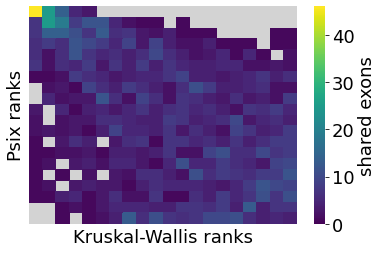

In [6]:
comparison, comparison_exons = make_comparison(geary_C.loc[tiklova_psix.index & geary_C.index], 
                                               tiklova_psix.loc[tiklova_psix.index & geary_C.index],
                             'C_score', 'L_score', bins=20)
mask = comparison == 0
                             
g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

In [7]:
pos_psix = tiklova_psix.index[(tiklova_psix.qvals <= 0.05) & (tiklova_psix.L_score > 0)] & tiklova_kw.index
pos_kw = tiklova_kw.index[tiklova_kw.qvals <= 0.05] & tiklova_psix.index

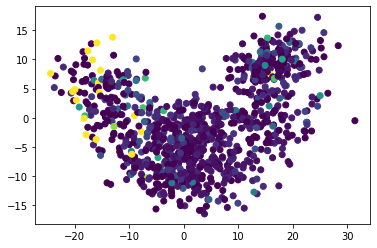

In [8]:
# Exon good for Psix, not for KW
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Snhg11_nmdSE_1', tiklova_neurogenesis_rd.index])

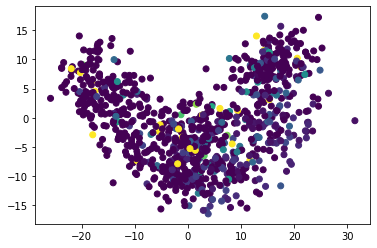

In [9]:
# Exon good for KW, not for Psix
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Syt1_3', tiklova_neurogenesis_rd.index])

In [10]:
# weyn_pvals = pd.read_csv(data_dir + 'weyn/Weyn_pvals.tab', sep='\t', index_col=0)
# weyn_fdr = pd.read_csv(data_dir + 'weyn/Weyn_fdr.tab', sep='\t', index_col=0)
# weyn_psi = pd.read_csv(data_dir + 'weyn/Weyn_psi.tab', sep='\t', index_col=0)

In [9]:
def L_upgma_step(cross_L_matrix, score_min = 0.1):
#     score_min = 0.1
    counter = 1
    for exon in cross_L_matrix.index:
        exon_max = cross_L_matrix.loc[exon].dropna().sort_values().index[-1]
        exon_pair = (exon, exon_max)
        pair_score = cross_L_matrix.loc[exon, exon_max]
        pair_score_r = cross_L_matrix.loc[exon_max, exon]
        if counter == 1:
            max_pair = exon_pair
            max_pair_score = pair_score
            max_pair_score_r = pair_score_r
        else:
            token_1 = (pair_score > max_pair_score) and (pair_score_r >= score_min)
            token_2 = (pair_score >= score_min) and (pair_score_r >= score_min) and (max_pair_score_r < score_min)
            if token_1 or token_2:
                max_pair = (exon, exon_max)
                max_pair_score = cross_L_matrix.loc[exon, exon_max]
                max_pair_score_r = cross_L_matrix.loc[exon_max, exon]
        counter += 1

    if (max_pair_score >= score_min) and (max_pair_score_r >= score_min):
        new_idx = [x for x in cross_L_matrix.index if x not in max_pair]
        new_df = cross_L_matrix.loc[new_idx, new_idx]

        combined_cross_1 = cross_L_matrix.loc[new_idx, list(max_pair)].mean(axis=1)
        combined_cross_2 = cross_L_matrix.loc[list(max_pair), new_idx].mean(axis=0)

        new_df[','.join(max_pair)] = combined_cross_2
        new_df = new_df.T
        new_df[','.join(max_pair)] = list(combined_cross_1) + [0]
        new_df = new_df.T
        
        return new_df
    else:
        print(max_pair_score)
        return [0]
            
            
def get_modules(cross_L_matrix, score_min = 0.0):
    counter = 1
    for i in tqdm(range(len(cross_L_matrix.index))):
        combined_cross = L_upgma_step(cross_L_matrix, score_min)
        if len(combined_cross) == 1:
            return cross_L_matrix
        else:
            cross_L_matrix = combined_cross
            
#         print(counter)
    return cross_L_matrix
        

In [10]:
x = tiklova_psix.sort_values('L_score').index
modules_psix = get_modules(tiklova_cross_psix)

 90%|████████▉ | 669/745 [08:27<00:57,  1.32it/s]

0.0275


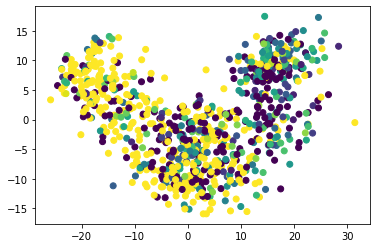

In [56]:
# Exon good for KW, not for Psix
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Ntan1_9', tiklova_neurogenesis_rd.index])

In [127]:
# css_out = get_modules(cross_super_sig, 0.01)
clusters = {}
counter = 0
for cluster in modules_psix.index:
    list_to_add = sorted(set(cluster.split(',')))
    if len(list_to_add) >= 10:
        clusters.update({counter:list_to_add})
        counter += 1

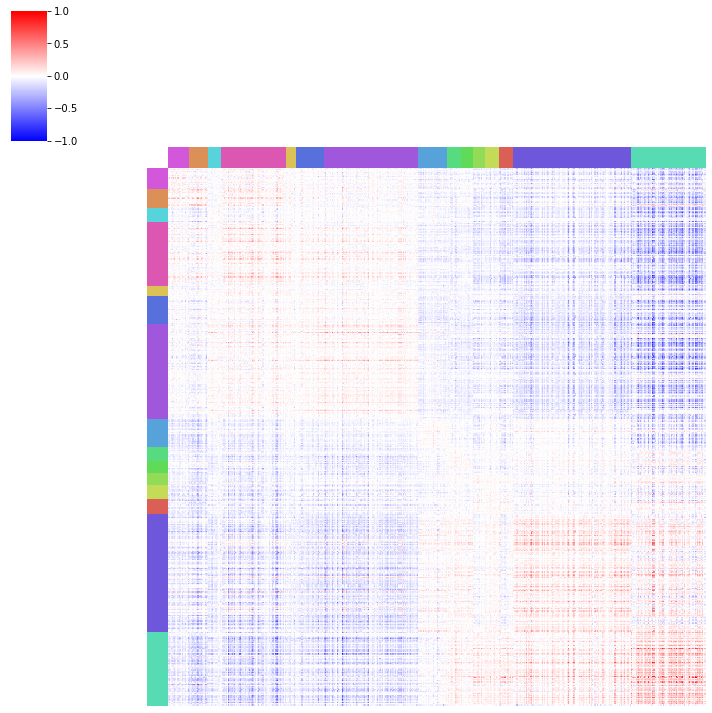

In [128]:
exons_list = []
for i in range(len(clusters.keys())):
# for i in [4, 0, 2, 3, 5, 1]:
    exons_list.extend(clusters[i])
    
colores = sns.color_palette("hls", 16)
exons_list = []
color_list = []
# for i in range(len(clusters.keys())):
for i in [13, 1, 8, 14, 2, 10, 12, 9, 6, 5, 4, 3, 0, 11, 7]:
    exons_list.extend(clusters[i])
    color_list.extend([colores[i]]*len(clusters[i]))
    
sns.clustermap(tiklova_cross_psix.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='bwr', vmin=-1, vmax=1,
              yticklabels=0, xticklabels=0)

In [160]:
tiklova_PSI.loc[exons_list]

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Alcam_1,NaN,NaN,0.764706,NaN,0.333333,NaN,0.428571,NaN,NaN,0.0,...,NaN,NaN,NaN,0.000000,NaN,0.000000,0.714286,0.000000,NaN,NaN
Dnajc5_nmdSE_1,0.000000,0.5,NaN,0.789474,0.846154,1.0,0.529412,0.0,0.538462,NaN,...,0.000000,0.0,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Dpf1_5,0.333333,1.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,1.0,...,0.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,1.000000,NaN,NaN
Emc10_7,0.000000,1.0,0.750000,0.000000,0.000000,0.0,0.714286,0.0,1.000000,1.0,...,0.000000,NaN,0.578947,0.200000,0.333333,0.437500,NaN,0.214286,0.333333,0.268293
Fance_2,NaN,NaN,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Srsf9_nmdSE_2,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.538462,1.0,0.500000,0.0,...,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
Stxbp1_2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.230769,0.0,0.128571,0.923077,0.544304,0.016393,0.600000,0.046154,0.444444,0.189873
Tpd52_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,...,1.000000,0.0,0.200000,NaN,NaN,1.000000,NaN,0.333333,1.000000,0.588235
Uqcr10_1,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.000000,0.0,NaN,NaN,...,0.000000,0.0,0.306122,0.071429,0.338983,0.211538,0.000000,0.000000,0.069767,0.010753


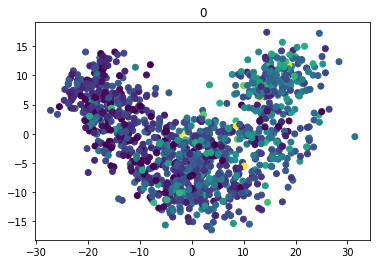

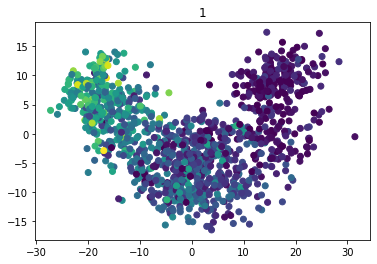

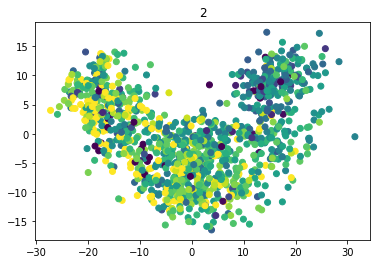

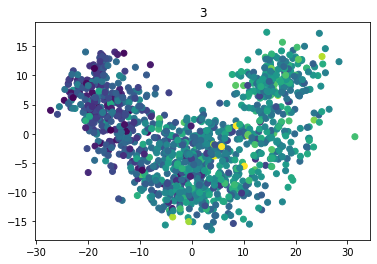

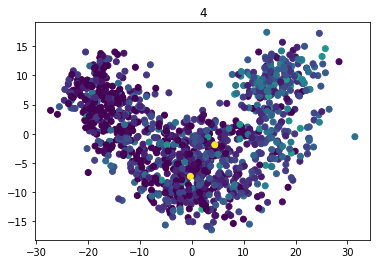

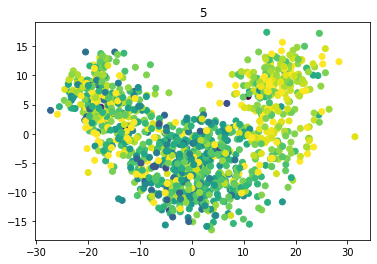

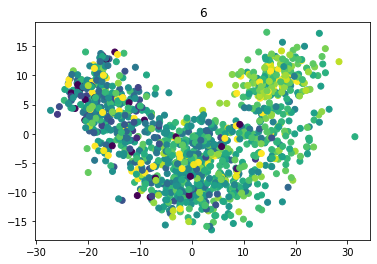

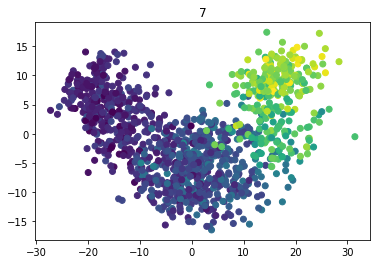

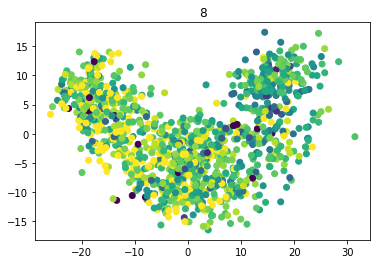

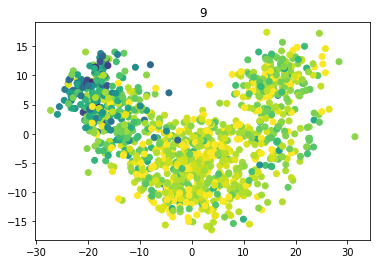

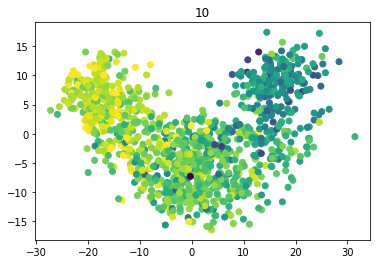

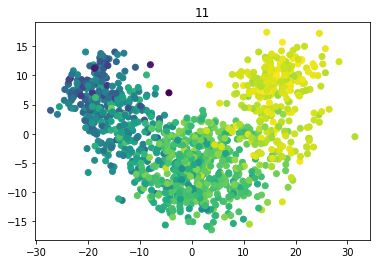

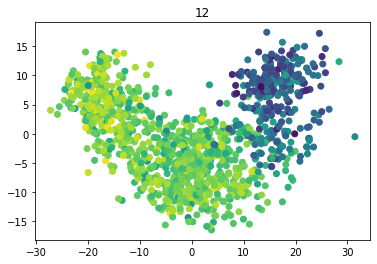

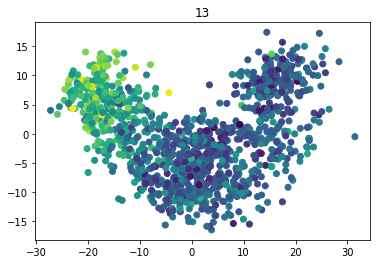

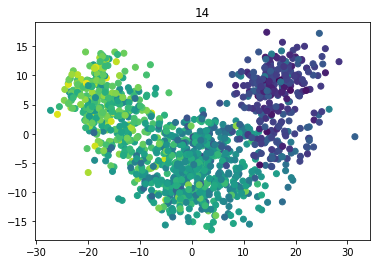

In [85]:
for i in clusters.keys():
    plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
                c = tiklova_PSI.loc[clusters[i]].mean(axis=0))
    plt.title(i)
    plt.show()

In [129]:
exon_list = []
for i in [13, 1, 8, 14, 2, 10, 12, 9, 6, 5, 4, 3, 0, 11, 7]:
    exon_list += clusters[i]

In [51]:
from sklearn.neighbors import NearestNeighbors
def get_distance_matrix(pca, k=100):
    print('token of change')
    nbrs = NearestNeighbors(n_neighbors=k).fit(pca)
    distances, indices = nbrs.kneighbors(pca)
    
    cells = list(pca.index)
    
    W = pd.DataFrame(np.zeros((len(cells), len(cells))))
    W.columns = cells
    W.index = cells
    
    for i in tqdm(range(len(cells))):
        cell_i = cells[i]
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            cell_j = cells[indices[i][j]]
            d = distances[i][j]
            w = np.exp(-(d**2)/(sigma**2))        
            W.loc[cell_i, cell_j] = w
    
    return W


W = get_distance_matrix(tiklova_neurogenesis_rd[['PC_1', 'PC_2']], k=100)

  0%|          | 5/1197 [00:00<00:29, 40.50it/s]

token of change


100%|██████████| 1197/1197 [00:23<00:00, 50.75it/s]


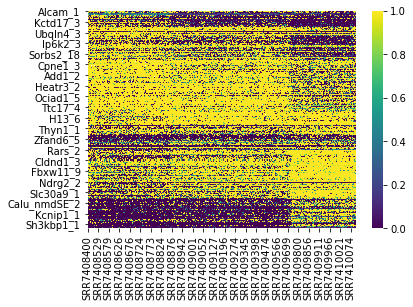

In [130]:
sns.heatmap(tiklova_PSI.loc[exon_list], cmap='viridis')

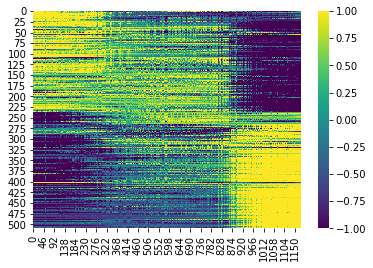

In [131]:
impute_mean = (tiklova_PSI.loc[exon_list, x].isna().astype(int).T*np.array(tiklova_PSI.loc[exon_list, x].T.mean())).T
tiklova_PSI_imputed = (tiklova_PSI.loc[exon_list, x].fillna(0) + impute_mean).drop_duplicates()


top_df = pd.DataFrame()

for exon in tiklova_PSI_imputed.index:

    exon_array = np.array(
        pd.DataFrame(np.array(W.loc[x, x])*np.array(tiklova_PSI_imputed.loc[exon, x])).sum(axis=1)
    )/np.array(W.loc[x, x].sum(axis=1))
    top_df[exon] = exon_array
    
top_df.index = x
top_df  = top_df.T

sns.heatmap(zscore(top_df, axis=1), vmin=-1, vmax=1, cmap='viridis')

In [132]:
len(exon_list)

510

In [143]:
exon_list2 = tiklova_cross_psix.index
impute_mean = (tiklova_PSI.loc[exon_list2, x].isna().astype(int).T*np.array(tiklova_PSI.loc[exon_list2, x].T.mean())).T
tiklova_PSI_imputed = (tiklova_PSI.loc[exon_list2, x].fillna(0) + impute_mean).drop_duplicates()

In [145]:
top_df = pd.DataFrame()

for exon in exon_list2:

    exon_array = np.array(
        pd.DataFrame(np.array(W.loc[x, x])*np.array(tiklova_PSI_imputed.loc[exon, x])).sum(axis=1)
    )/np.array(W.loc[x, x].sum(axis=1))
    top_df[exon] = exon_array
    
top_df.index = x
top_df  = top_df.T

0


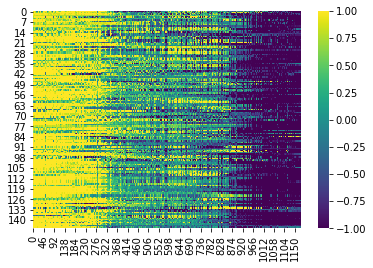

1


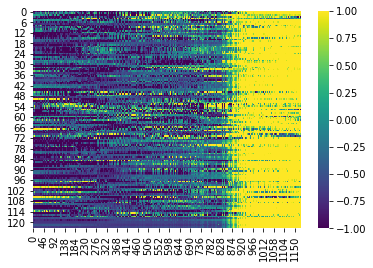

2


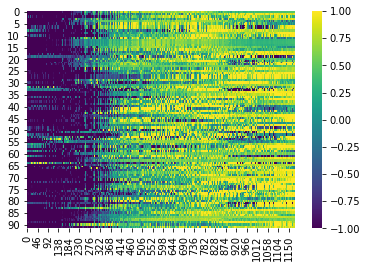

3


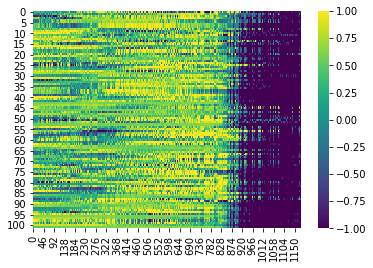

4


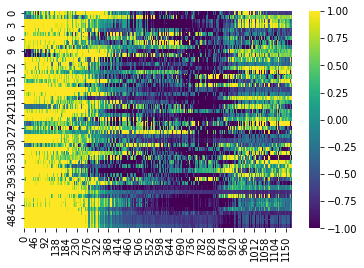

5


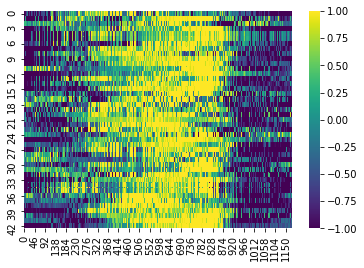

6


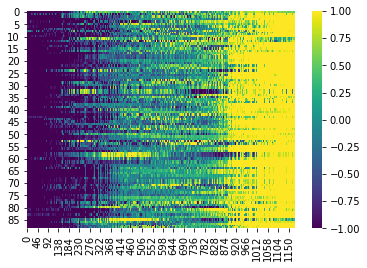

7


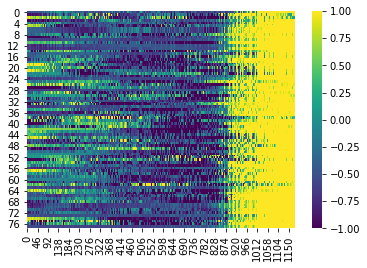

8


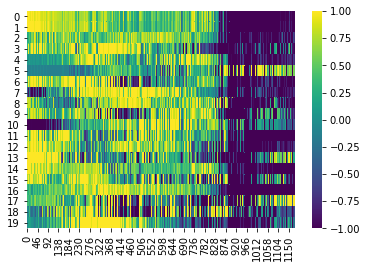

In [146]:

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
labels = AgglomerativeClustering(n_clusters=9).fit(zscore(top_df, axis=1)).labels_
# labels = AgglomerativeClustering(n_clusters=8).fit(top_df).labels_

for cluster in range(9):
    print(cluster)
    sns.heatmap(zscore(top_df.loc[labels == cluster], axis=1), cmap='viridis', vmax=1, vmin=-1)
#     sns.heatmap(tiklova_PSI.loc[top_df.loc[labels == cluster].index, x], cmap='viridis')
    plt.show()

In [151]:
exon_list3 = []
for cluster in [0, 4, 3, 8, 5, 2, 6, 1, 7]:
    exon_list3 += list(top_df.loc[labels == cluster].index)

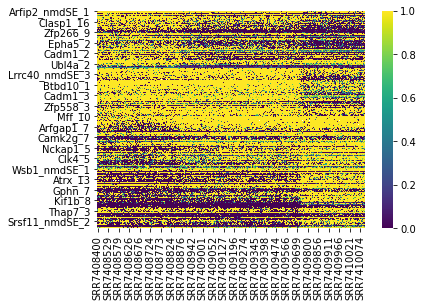

In [152]:
sns.heatmap(tiklova_PSI.loc[exon_list3], cmap='viridis')

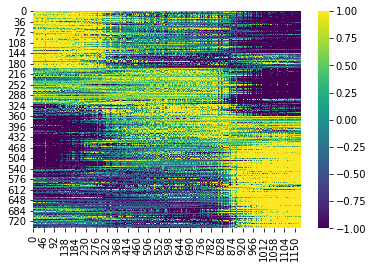

In [153]:
sns.heatmap(zscore(top_df.loc[exon_list3], axis=1), vmin=-1, vmax=1, cmap='viridis')

In [142]:
len(exon_list3)

510

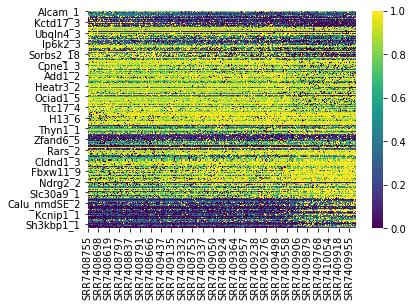

In [107]:
sns.heatmap(tiklova_PSI_imputed, cmap='viridis')

In [38]:
pseudotime = pd.read_csv('~/data_sc_regulation/tiklova/pseudotime.tab', sep='\t', index_col=0)
x = pseudotime.loc[tiklova_neurogenesis_rd.index].lineage_1_pseudotime.dropna().sort_values().index

# Kruskal Wallis

In [164]:
exons_kw = tiklova_kw.loc[tiklova_kw.qvals <= 0.05].index

In [165]:
tiklova_PSI.loc[exons_kw]

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Aftph_4,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,1.0
Agrn_8,NaN,NaN,1.000000,NaN,0.000000,NaN,1.000000,1.000000,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
Angel2_1,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,1.0
Arfip2_nmdSE_1,1.000000,NaN,NaN,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,...,1.0,1.0,1.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,1.0
Bclaf1_1,NaN,NaN,NaN,1.000000,0.000000,0.000000,1.000000,NaN,0.454545,1.000000,...,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,1.000000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mapt_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.068966,...,1.0,1.0,0.983333,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
Meg3_2,0.388889,0.245714,0.342776,0.404762,0.454545,0.571429,0.576642,0.102041,0.355932,0.333333,...,0.0,NaN,0.117166,0.0,0.352941,0.089059,0.019608,0.147766,0.357143,0.0
Nnat_2,0.473684,0.435897,0.500000,0.333333,0.446429,0.777778,0.358974,0.243590,0.481481,0.416667,...,NaN,NaN,0.072165,NaN,NaN,0.074286,NaN,0.094737,NaN,NaN
Nnat_3,0.473684,0.435897,0.538462,0.333333,0.474576,0.800000,0.358974,0.243590,0.508772,0.533333,...,NaN,NaN,0.067358,NaN,NaN,0.074286,NaN,0.113402,NaN,NaN


In [ ]:
from itertools import combinations
KW_pearson = pd.DataFrame(np.identity(len(exons_kw)))
KW_pearson.columns = exons_kw
KW_pearson.index = exons_kw
for pair in tqdm(list(combinations(exons_kw, r=2))):
    try:
        cells = tiklova_PSI.loc[[pair[0], pair[1]]].T.dropna().index
        corre = pearsonr(tiklova_PSI.loc[pair[0], cells], tiklova_PSI.loc[pair[1], cells])[0]
        KW_pearson.loc[pair[0], pair[1]] = corre
        KW_pearson.loc[pair[1], pair[0]] = corre
        
    except:
        continue

 28%|██▊       | 172025/611065 [13:04<31:21, 233.37it/s]

In [179]:
cells

,SRR7408414,SRR7408472,SRR7408485,SRR7408494,SRR7408517,SRR7408518,SRR7408540,SRR7408544,SRR7408547,SRR7408548,...,SRR7409974,SRR7410003,SRR7410004,SRR7410027,SRR7410028,SRR7410031,SRR7410037,SRR7410052,SRR7410058,SRR7410092
Aftph_4,1.0,1.0,1.00,1.0,1.000000,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Agrn_8,0.0,1.0,0.75,1.0,0.333333,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
